#1 Install Libraries

In [ ]:
!pip install tensorflow_addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 5.7 MB/s eta 0:00:00


In [ ]:
!pip3 install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 40.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 45.2 MB/s eta 0:00:00


#2 Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import Input, Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Bidirectional, LSTM, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

from transformers import TFAutoModel, AutoTokenizer

from sklearn.model_selection import train_test_split


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


#3 Load Data

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/DataMining/BTL/data/comments.csv',
                 usecols = ['rating', 'content'])
df.head()

,rating,content
0,5,"Có những người bước đến, họ lấp đầy hạnh phúc ..."
1,5,"Thấy nhiều bạn chê tiki gói hàng quá, may sao ..."
2,5,"Bìa cực xinh, tiki giao hàng nhanh, sách không..."
3,5,"Sách lúc nhận hình thức rất ổn, không cong vên..."
4,5,Một cuốn sách rất đáng đọc về tình yêu thương ...


#4 Data Preparation

In [ ]:
print(f'Len of train dataset: {len(df)}')

Len of train dataset: 141281


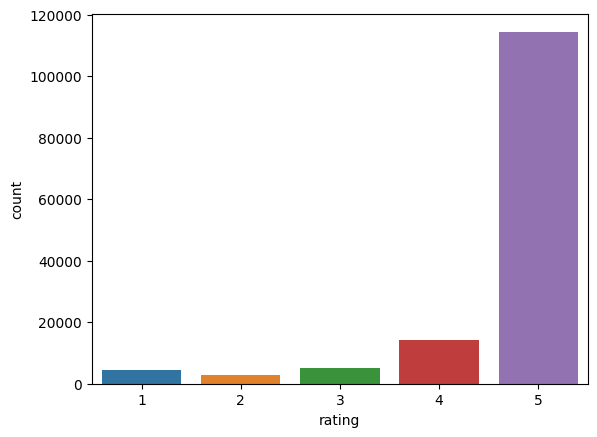

In [ ]:
sns.countplot(x = df.rating);

##4.1 Missing Values

In [ ]:
df.isna().sum()

rating         0
content    38018
dtype: int64

In [ ]:
df = df.dropna()

In [ ]:
df.shape

(103263, 2)

##4.2 Split dataset

In [ ]:
X = df.content.copy()
y = df.rating.copy()

##4.3 Target value

chuyển đổi y thành dạng ma trận nhị phân (one-hot encoding).

In [ ]:
y = tf.keras.utils.to_categorical(y)

In [ ]:
y.shape

(103263, 6)

##4.4 TPU setup

xác định và tạo các chiến lược phân phối dữ liệu và tính toán phù hợp cho môi trường huấn luyện dựa trên sự có mặt của TPU, GPU hoặc CPU trong hệ thống.







In [ ]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)

    strategy = tf.distribute.experimental.TPUStrategy
except ValueError:
    strategy = tf.distribute.get_strategy()
    print('Number of replicas:', strategy.num_replicas_in_sync)

In [ ]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
except ValueError:
    tpu = None
    gpus = tf.config.experimental.list_logical_devices("GPU")

if tpu:
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu,)
    print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
elif len(gpus) > 1:
    strategy = tf.distribute.MirroredStrategy([gpu.name for gpu in gpus])
    print('Running on multiple GPUs ', [gpu.name for gpu in gpus])
elif len(gpus) == 1:
    strategy = tf.distribute.get_strategy()
    print('Running on single GPU ', gpus[0].name)
else:
    strategy = tf.distribute.get_strategy()
    print('Running on CPU')
print("Number of accelerators: ", strategy.num_replicas_in_sync)

Running on TPU  ['10.5.54.114:8470']
Number of accelerators:  8


##4.5 Build Model

In [ ]:
MAX_LEN = 200
model_name = 'vinai/phobert-base'

# Tokenizing
tokenizer = AutoTokenizer.from_pretrained(model_name)
inputs = [tokenizer(item,
                    max_length = MAX_LEN,
                    padding = 'max_length',
                    truncation = True,
                    return_tensors = 'np')['input_ids'].reshape(MAX_LEN)
          for _, item in X.items()]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


tách df train, test theo tỉ lệ 8:2 với seed random là 1905

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(np.asarray(inputs),
                                                    y,
                                                    random_state=1905,
                                                    test_size=0.2,
                                                    shuffle=True)

In [ ]:
# Build model
with strategy.scope():
    encoder = TFAutoModel.from_pretrained(model_name)

    input_ids = Input(shape=(MAX_LEN,), dtype=tf.int32)

    embedding = encoder(input_ids)[1]

    x = Dense(128, activation = 'relu', kernel_regularizer = regularizers.L2(0.1))(embedding)
    x = Dropout(0.2)(x)

    x = Dense(y.shape[1],
              activation = 'softmax',
              kernel_initializer=tf.initializers.GlorotUniform(seed=1905),
              name='output_layer')(x)

    model = Model(inputs=[input_ids], outputs = x)

Some layers from the model checkpoint at vinai/phobert-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at vinai/phobert-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200)]             0         
                                                                 
 tf_roberta_model (TFRoberta  TFBaseModelOutputWithPoo  134998272
 Model)                      lingAndCrossAttentions(l            
                             ast_hidden_state=(None,             
                             200, 768),                          
                              pooler_output=(None, 76            
                             8),                                 
                              past_key_values=None, h            
                             idden_states=None, atten            
                             tions=None, cross_attent            
                             ions=None)                          
                                                             

In [ ]:
step = tf.Variable(0, trainable=False)
schedule = tf.optimizers.schedules.PiecewiseConstantDecay(
    [10000, 15000], [1e-3, 1e-4, 1e-5])

lr = 1e-2 * schedule(step)
wd = lambda: 1e-5 * schedule(step)

In [ ]:
model.compile(
    optimizer=tfa.optimizers.AdamW(weight_decay=wd,
                                   learning_rate=lr),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy'])

In [ ]:
# Train the model
history = model.fit(X_train,
                    y_train,
                    epochs = 20,
                    verbose = 1,
                    validation_split = 0.1,
                    batch_size = 256)

Epoch 1/20
291/291 [==============================] - 367s 566ms/step - loss: 21.6110 - accuracy: 0.7714 - val_loss: 20.3288 - val_accuracy: 0.7974
Epoch 2/20
291/291 [==============================] - 100s 344ms/step - loss: 19.2934 - accuracy: 0.8065 - val_loss: 18.2552 - val_accuracy: 0.8147
Epoch 3/20
291/291 [==============================] - 100s 344ms/step - loss: 17.3361 - accuracy: 0.8191 - val_loss: 16.4178 - val_accuracy: 0.8195
Epoch 4/20
291/291 [==============================] - 100s 345ms/step - loss: 15.5731 - accuracy: 0.8248 - val_loss: 14.7411 - val_accuracy: 0.8284
Epoch 5/20
291/291 [==============================] - 101s 348ms/step - loss: 13.9609 - accuracy: 0.8323 - val_loss: 13.2155 - val_accuracy: 0.8292
Epoch 6/20
291/291 [==============================] - 100s 344ms/step - loss: 12.4913 - accuracy: 0.8399 - val_loss: 11.8310 - val_accuracy: 0.8311
Epoch 7/20
291/291 [==============================] - 100s 344ms/step - loss: 11.1548 - accuracy: 0.8464 - val_l

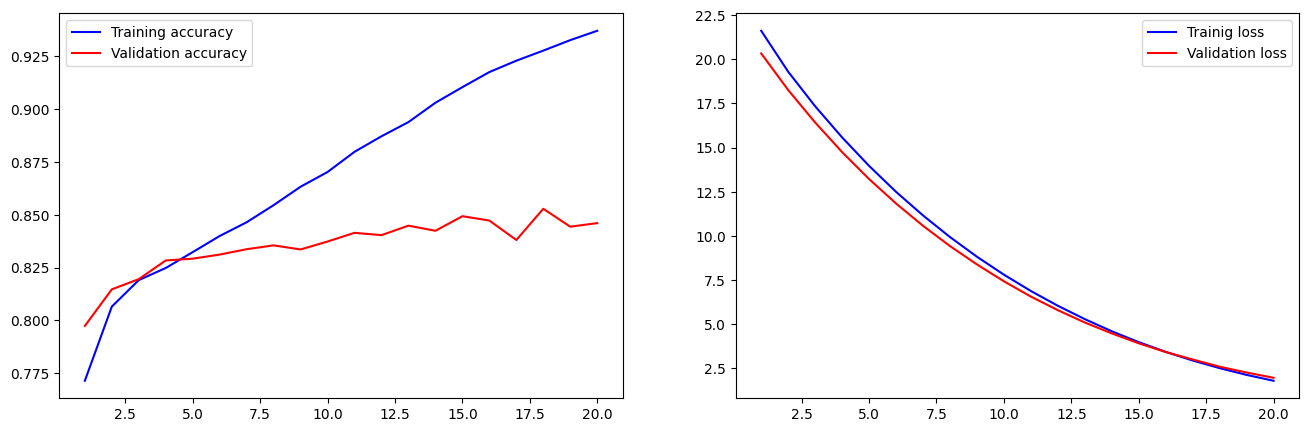

In [ ]:
loss = history.history['loss']
acc = history.history['accuracy']
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']

epochs = range(1, len(loss) + 1)

plt.figure(figsize=(16, 5))
# Accuracy
plt.subplot(1,2,1)
plt.plot(epochs, acc, 'b', label = 'Training accuracy')
plt.plot(epochs, val_acc, 'r', label = 'Validation accuracy')
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(epochs, loss, 'b', label = 'Trainig loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation loss')
plt.legend()

plt.show()

In [ ]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(X_test, y_test, batch_size=256)
print("test loss, test acc:", results)

Evaluate on test data
81/81 [==============================] - 16s 183ms/step - loss: 1.9385 - accuracy: 0.8504
test loss, test acc: [1.9384721517562866, 0.850433349609375]


Mô hình có khả năng học tốt từ tập dữ liệu huấn luyện và cải thiện kết quả theo số lần thực hiện.
Mô hình có xu hướng bị overfitting, tức là nó hoạt động tốt trên tập dữ liệu huấn luyện nhưng không hoạt động tốt trên tập dữ liệu mới hoặc chưa biết. Điều này có thể được nhận biết qua sự chênh lệch giữa hai đường xanh và đỏ trong biểu đồ bên trái, và hai đường đỏ và tím trong biểu đồ bên phải.